## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Refrences](#ref)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists. 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability


In [1]:
# import the required libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid')

# set the seed to assure getting the same answers on quizzes
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [5]:
df.query('converted == 1')['user_id'].nunique() / df['user_id'].nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df.query('group == "treatment" and landing_page != "new_page"').user_id.nunique() + \
df.query('group != "treatment" and landing_page == "new_page"').user_id.nunique()

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# create a new dataframe that don't include the rows where the landing_page and group don't match 
df2 = df.query('(group == "treatment" and landing_page == "new_page") or (group == "control" and landing_page == "old_page")')
df2.shape[0]

290585

In [9]:
# double check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.duplicated(['user_id'])]['user_id']

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2.drop_duplicates(subset = "user_id", inplace = True)
df2.shape[0]

C:\Users\ftoom\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


290584

In [14]:
# double check that the row with the duplicated id was removed
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df_control = df2.query('group == "control"')
df_control['converted'].mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df_treatment = df2.query('group == "treatment"')
df_treatment['converted'].mean()

0.11880806551510564

In [18]:
# the difference in the conversion rates of both groups
obs_diff = df_treatment['converted'].mean() - df_control['converted'].mean()
obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [19]:
(df2['landing_page'] == "new_page").mean()

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Given that the population in this experiment has been fairly divided among the two groups, as 50% of the population were part of the treatment group and received the new page as the landing page. The above results show that the conversions rates of users from both groups are close to each other, and even the probability of converted users in the control group is slightly higher than the treatment group by 0.16%.**

**Therefore, there is no sufficient evidence to conclude that the new page increases the conversions and we need to set our hypothesis to perform an A/B test to make sure whether this change is significant or not.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{old} \geq p_{new}$$


$$H_1: p_{old} < p_{new}$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = df2['converted'].mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [22]:
n_new = df_treatment.shape[0]
n_new

145310

d. What is $n_{old}$?

In [23]:
n_old = df_control.shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.choice(a = [0,1] , size = n_new , p = [1 - p_new , p_new])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.choice(a = [0,1] , size = n_old , p = [1 - p_old , p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
new_page_converted.mean() - old_page_converted.mean()

-0.0022527154677071393

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [27]:
p_diffs = []

for _ in range(10000):
    
    new_page_converted = np.random.choice(a = [0,1] , size = n_new , p = [1 - p_new , p_new])
    old_page_converted = np.random.choice(a = [0,1] , size = n_old , p = [1 - p_old , p_old])
    
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

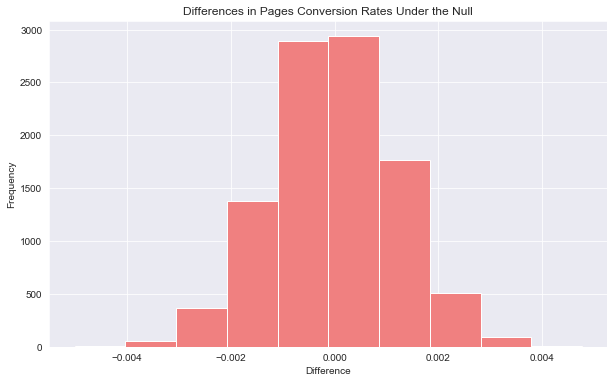

In [28]:
p_diffs = np.array(p_diffs)

plt.figure(figsize = (10,6))
plt.hist(p_diffs , color = "lightcoral")
plt.title('Differences in Pages Conversion Rates Under the Null')
plt.xlabel('Difference')
plt.ylabel('Frequency');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

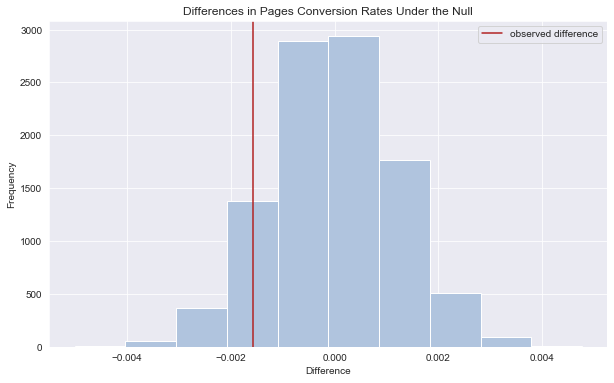

In [29]:
plt.figure(figsize = (10,6))
plt.hist(p_diffs , color = "lightsteelblue")
plt.axvline(x = obs_diff , color = 'firebrick' ,  label="observed difference")
plt.title('Differences in Pages Conversion Rates Under the Null')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.legend();

In [30]:
# the proportion of the p_diffs values which are greater than the observed difference 
(p_diffs > obs_diff).mean()

0.9062

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The calculated value is called P-value, and it represents the probability of getting the observed statistic or more extreme in favor of the alternative hypothesis, assuming that the null hypothesis is true.**

**Based on the P-value that we got (0.9062), which is greater than our Type I error rate (5%), we have evidence that our statistic (the observed difference) was likely to be come from the null hypothesis. Therefore, we failed to reject the null.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
# the number of conversions for each page
convert_old = df_control.query('converted == 1').shape[0]
convert_new = df_treatment.query('converted == 1').shape[0]

# the number of individuals who received each page
n_old = df_control.shape[0]
n_new = df_treatment.shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [32]:
import statsmodels.api as sm
z_score , p_value = sm.stats.proportions_ztest(count = [convert_old , convert_new], nobs = [n_old , n_new], alternative='smaller')
z_score , p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The computed z-score and p-value from the z-test indicate that we fail to reject the null, and this complies with the results we got in parts i and j.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Since we want to predict only 2 possible outcomes, we will perform Logistic Regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
# add an intercept column
df2['intercept'] = 1

# create dummy variables columns for the landing page
df2 = df2.join(pd.get_dummies(df2['landing_page']))

# drop old_page column
df2.drop('old_page' , axis = 1 , inplace = True)

# rename new_page column to ab_page
df2.rename(columns = {'new_page' : 'ab_page'} , inplace = True)

df2.head()

C:\Users\ftoom\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [34]:
# instantiate a logistic regression model
log_model = sm.Logit(df2['converted'] , df2[['intercept' , 'ab_page']])

# fit the model
results = log_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [35]:
# obtain the results
print(results.summary())

                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Sat, 18 Jul 2020   Pseudo R-squ.:               8.077e-06
Time:                        02:47:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007


e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Since the p-value that we got from our model (19%) is greater than the Type I error rate (5%), this suggests that the ap_page is not statically significant for predicting whether a user will convert or not.**

**This value differs from the p-value resulted from the A/B test because the p-value in regression is given for testing if the parameter for the intercept or the slope are equal to 0 or not, and based on that we can then conclude if a given explanatory variable has statistical significant relationship with our response variable or not.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Based on the results we have so far, the experiment group in which an individual belongs to didn't provide us with any helpful information to understand what the conversions influenced by. And here comes the importance of considering other factors such as the users ages, educational level, the amount of time a user spent in the landing page, and the time of the day in which the user accessed that page.**

**Some disadvantages might arise as a result of including multiple explanatory variables in our regression model, one of them is Multicollinearity, as there could be high intercorrelation among these variables which will result in creating disturbance in our data, and affect our statistical results negatively which will make it unreliable.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [36]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [37]:
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [38]:
# check the unique values in country column
countries_df['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [39]:
# create the necessary dummy variables
df_new = df_new.join(pd.get_dummies(df_new['country']))
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [40]:
# instantiate a logistic regression model with CA as the baseline
log_model2 = sm.Logit(df_new['converted'] , df_new[['intercept' , 'ab_page' , 'UK' , 'US']])

# fit the model and obtain the results
results2 = log_model2.fit()
print(results2.summary())

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Sat, 18 Jul 2020   Pseudo R-squ.:               2.323e-05
Time:                        02:47:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.

**The p-values associated with the countries variables suggest that the country is also not statically significant for predicting whether a user will convert or not, since they are greater than the Type I error rate.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
# add interaction columns
df_new['UK_ap_page'] = df_new['ab_page'] * df_new['UK']
df_new['US_ap_page'] = df_new['ab_page'] * df_new['US']

df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,UK_ap_page,US_ap_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0


In [42]:
# instantiate a logistic regression model with CA as the baseline
log_model3 = sm.Logit(df_new['converted'] , df_new[['intercept' , 'ab_page' , 'UK' , 'US' , 'UK_ap_page' , 'US_ap_page']])

# fit the model and obtain the results
results3 = log_model3.fit()
print(results3.summary())

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Sat, 18 Jul 2020   Pseudo R-squ.:               3.482e-05
Time:                        02:47:47   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.

**Even after adding higher order terms in our model, the resultant p-values suggest that the interaction between our explanatory variables (the landing page and the country) don't have statistical significant relationship with our response variable since all of them are greater than 5%. Therefore, we have no evidence that these x-variables could help us in predicting the conversion of a user, which means we still fail to reject the null hypothesis.**

Before drawing our conclusion, let's find out the duration in which this experiment has been run.

In [43]:
# check the timestamp columns data type
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 834778 to 934996
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   country       290584 non-null  object
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
 5   intercept     290584 non-null  int64 
 6   ab_page       290584 non-null  uint8 
 7   CA            290584 non-null  uint8 
 8   UK            290584 non-null  uint8 
 9   US            290584 non-null  uint8 
 10  UK_ap_page    290584 non-null  uint8 
 11  US_ap_page    290584 non-null  uint8 
dtypes: int64(2), object(4), uint8(6)
memory usage: 27.2+ MB


In [44]:
# change the type of the timestamp column to datetime
df_new['timestamp'] = pd.to_datetime(df_new['timestamp'])

# find the duration of the entire experiment
max(df_new['timestamp']) - min(df_new['timestamp'])

Timedelta('21 days 23:59:49.081927')

<a id='conclusions'></a>
## Conclusions

**According to the results that we got from this experiment, there is no evidence that lunching the new page will drive more user conversions, which makes us fail to reject the null that states that the old page drives as mush conversions as the new page or higher. This conclusion is not necessarily an indication that the old page is better than the new one, since the duration of this experiment is considerably short as it has been run for only 21 days. Which means that the produced results might be bias due to the existence of change aversion or novelty effect problems.**

**I would recommend the company to run the experiment for a longer period of time before taking their final actions, in addition to considering additional factors for understanding what influences the conversion of users since the results we got from our regression model suggested that both the page and country don't have significance in predicting the conversion of users.**

In [45]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0

<a id='ref'></a>
## Refrences:

1. https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html
2. https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/
3. https://www.simplypsychology.org/z-score.html#:~:text=The%20value%20of%20the%20z,are%20away%20from%20the%20mean.&text=A%20positive%20z%2Dscore%20indicates,is%20below%20the%20mean%20average.
4. https://www.statisticssolutions.com/multicollinearity/
5. https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html